In [1]:
# Pkg.add("Cairo");
using Distributions

mu = [10 20 30 40]';
Lambda =
[1.0 0 0
 0 1.0 0
 0 0 1.0
 0.5 0.5 0];
Psi = diagm([0.1, 0.2, 0.3, 0.4]);
d1 = MvNormal([0,0,0],ones(3));
X = zeros(50,4);
for i=1:50
f = rand(d1,1);
d2 = MvNormal(vec(mu+ Lambda*f),Psi);
x = rand(d2,1);
X[i,:] = x';
end
X

50×4 Array{Float64,2}:
 10.1719   18.4163  30.6688  38.7584
 10.63     22.1694  29.2598  41.0839
  9.36688  19.5018  31.2387  39.9203
  9.26217  19.3691  30.8179  40.1884
 10.2573   19.1771  28.2707  39.8336
 11.3608   18.7009  32.5208  40.0868
 11.1408   21.2319  28.7629  40.9787
 10.2027   20.3814  30.6974  39.7087
  9.65973  21.1015  31.4924  40.4516
  9.26646  20.4001  28.6904  40.5777
 11.4334   20.6044  31.6017  40.9151
  8.93927  22.0548  30.6187  40.0644
 10.4191   20.8651  31.3216  40.3739
  ⋮                                 
  7.33926  18.8322  29.7758  38.7784
  9.93475  21.15    27.7688  40.9617
  8.29452  18.3925  30.9478  40.0767
  9.1321   20.7882  30.3869  39.7228
 11.2158   22.225   30.5573  42.6165
  9.69202  19.094   30.9138  40.1953
 10.3983   22.1094  28.5171  41.5112
 10.5754   19.3998  28.6086  40.4075
 10.5227   20.3018  29.7517  39.9025
 11.3243   19.0142  28.7557  40.8227
  8.65663  20.1532  30.6168  39.1994
 11.193    18.3596  28.9776  38.9614

In [2]:
function E_Step(X,mu,Lambda,Psi,k)
mu_f_by_x = (X - repmat(mu',size(X,1),1))*(Lambda'*inv(Lambda*Lambda' + Psi))';
Sig_f_by_x = eye(k) - Lambda'*inv(Lambda*Lambda' + Psi)*Lambda;
return mu_f_by_x,Sig_f_by_x;
end


E_Step (generic function with 1 method)

In [3]:
function M_Step(X,mu_f_by_x,Sig_f_by_x,k)
nrows, ncols = size(X);
#Computing mu
mu = mean(X,1)';
#Computing Lambda
Lambda_term1 = zeros(ncols,k);
Lambda_term2 = zeros(k,k);
for i=1:nrows
Lambda_term1 = Lambda_term1 + ((X[i,:] - mu)*mu_f_by_x[i,:]');
Lambda_term2 = Lambda_term2 + (mu_f_by_x[i,:]*mu_f_by_x[i,:]')+Sig_f_by_x; 
end
Lambda = Lambda_term1*Lambda_term2;
#Computing Psi
Phi = zeros(ncols,ncols);
for i=1:nrows
Phi = Phi + (X[i,:]*X[i,:]' - X[i,:]*mu_f_by_x[i,:]'*Lambda' - Lambda*mu_f_by_x[i,:]*X[i,:]' + Lambda*(mu_f_by_x[i,:]*mu_f_by_x[i,:]'+Sig_f_by_x)*Lambda')
end
Psi = diagm(diag(Phi./nrows));
return mu, Lambda, Psi
end
function compute_llh(X,mu,Lambda,Psi)
llh = 0;
for i=1:size(X,1)
llh = llh + log(pdf(MvNormal(vec(mu),(Lambda*Lambda')+Psi),X[i,:]));
end
return llh;
end

compute_llh (generic function with 1 method)

In [4]:
function fa_em(X,k)
    max_Iter = 100;
    eps = 0.0001;
    llh = -Inf*ones(max_Iter+1);
    mu = mean(X,1)';
    Lambda = rand(size(X,2),k);
    Psi = diagm(rand(size(X,2)));
    print(mu,"\n",Lambda,"\n",Psi,"\n");
    llh[1] = compute_llh(X,mu,Lambda,Psi);
    print(llh[1],"\n")
    for i=1:max_Iter
    print(i,"\n");
    mu_f_by_x,Sig_f_by_x = E_Step(X,mu,Lambda,Psi,k);
    mu_new, Lambda_new, Psi_new = M_Step(X,mu_f_by_x,Sig_f_by_x,k);
    print(mu_new,"\n",Lambda_new,"\n",Psi_new,"\n");
    llh[i+1] = compute_llh(X,mu_new,Lambda_new,Psi_new);
    print(llh[i+1],"\n");
    if(sum(abs.(mu_new-mu))<eps && sum(abs.(Lambda_new-Lambda))<eps && sum(abs.(Psi_new-Psi))<eps)
        break;
    end
    mu = mu_new;
    Lambda = Lambda_new;
    Psi = Psi_new;
    end
    mu_f_by_x,Sig_f_by_x = E_Step(X,mu,Lambda,Psi,k);
    return (mu, Lambda, Psi, mu_f_by_x, Sig_f_by_x, llh);
end

fa_em (generic function with 1 method)

In [5]:
#Calling the EM approach for dataset X and 3 factors
mu, Lambda, Psi, mu_f_by_x, Sig_f_by_x, llh = fa_em(X,3)


[10.0145; 19.9223; 30.0799; 40.0507]
[0.661907 0.0443072 0.79368; 0.28113 0.243309 0.482629; 0.687835 0.760386 0.845979; 0.458782 0.358715 0.942856]
[0.204234 0.0 0.0 0.0; 0.0 0.977252 0.0 0.0; 0.0 0.0 0.161242 0.0; 0.0 0.0 0.0 0.899821]
-330.1677079305067
1
[10.0145; 19.9223; 30.0799; 40.0507]
[1115.57 -4716.82 1502.35; -409.297 -207.251 485.482; -405.952 5482.49 -1562.72; 24.4302 -1852.3 915.948]
[5.44888e7 0.0 0.0 0.0; 0.0 5.37257e5 0.0 0.0; 0.0 0.0 6.91585e7 0.0; 0.0 0.0 0.0 8.88046e6]
-1846.1274068991083
2
[10.0145; 19.9223; 30.0799; 40.0507]
[0.0334714 -0.0652755 0.0169742; -0.948968 0.130638 0.855101; -0.0246345 0.0637834 0.0160629; -0.423554 0.00989048 0.416816]
[101.241 0.0 0.0 0.0; 0.0 399.269 0.0 0.0; 0.0 0.0 906.035 0.0; 0.0 0.0 0.0 1605.02]
-804.1904837252112
3
[10.0145; 19.9223; 30.0799; 40.0507]
[0.515213 -1.53922 0.657516; -8.46423 1.09814 7.67762; -0.204225 0.477812 -0.0265806; -4.04948 0.0326918 4.04317]
[104.303 0.0 0.0 0.0; 0.0 529.385 0.0 0.0; 0.0 0.0 906.303 0.0; 

[4.71359 -6.95536 2.96165; -15.5404 3.59819 12.2913; 11.5415 16.214 14.0501; -6.76644 -1.49095 7.33867]
[133.808 0.0 0.0 0.0; 0.0 581.91 0.0 0.0; 0.0 0.0 1305.57 0.0; 0.0 0.0 0.0 1644.87]
-864.7108384207107
40
[10.0145; 19.9223; 30.0799; 40.0507]
[19.7366 -49.2419 32.9355; -28.8382 -3.66563 29.9661; 11.25 24.8655 9.15922; -9.17355 -18.5559 25.3997]
[2644.07 0.0 0.0 0.0; 0.0 1441.68 0.0 0.0; 0.0 0.0 1466.76 0.0; 0.0 0.0 0.0 2338.68]
-995.189153713567
41
[10.0145; 19.9223; 30.0799; 40.0507]
[4.71078 -6.95304 2.96205; -15.546 3.59937 12.2953; 11.5406 16.2126 14.0496; -6.76926 -1.48996 7.34089]
[133.782 0.0 0.0 0.0; 0.0 582.028 0.0 0.0; 0.0 0.0 1305.52 0.0; 0.0 0.0 0.0 1644.9]
-864.7110356661149
42
[10.0145; 19.9223; 30.0799; 40.0507]
[19.7367 -49.2524 32.9452; -28.8346 -3.65967 29.9548; 11.2502 24.8681 9.15796; -9.17175 -18.5562 25.3971]
[2645.51 0.0 0.0 0.0; 0.0 1440.87 0.0 0.0; 0.0 0.0 1466.86 0.0; 0.0 0.0 0.0 2338.52]
-995.187853299573
43
[10.0145; 19.9223; 30.0799; 40.0507]
[4.70852 -

[10.0145; 19.9223; 30.0799; 40.0507]
[19.5779 -49.2474 33.0915; -28.8807 -3.55117 29.868; 11.2766 24.8683 9.13526; -9.24727 -18.4987 25.4003]
[2648.2 0.0 0.0 0.0; 0.0 1438.17 0.0 0.0; 0.0 0.0 1467.05 0.0; 0.0 0.0 0.0 2338.0]
-995.1584429823746
79
[10.0145; 19.9223; 30.0799; 40.0507]
[4.68733 -6.95222 2.98476; -15.5867 3.6566 12.2689; 11.5367 16.2145 14.0454; -6.79718 -1.4606 7.33561]
[133.744 0.0 0.0 0.0; 0.0 582.521 0.0 0.0; 0.0 0.0 1305.43 0.0; 0.0 0.0 0.0 1645.0]
-864.7334567260618
80
[10.0145; 19.9223; 30.0799; 40.0507]
[19.5679 -49.2456 33.0993; -28.8844 -3.54503 29.8643; 11.2782 24.868 9.13401; -9.25244 -18.495 25.4009]
[2648.17 0.0 0.0 0.0; 0.0 1438.14 0.0 0.0; 0.0 0.0 1467.05 0.0; 0.0 0.0 0.0 2338.0]
-995.1572581081288
81
[10.0145; 19.9223; 30.0799; 40.0507]
[4.68628 -6.95247 2.98609; -15.5882 3.6598 12.2667; 11.5366 16.2147 14.0452; -6.7984 -1.459 7.33494]
[133.745 0.0 0.0 0.0; 0.0 582.53 0.0 0.0; 0.0 0.0 1305.43 0.0; 0.0 0.0 0.0 1645.0]
-864.7343666217073
82
[10.0145; 19.9223

([10.0145; 19.9223; 30.0799; 40.0507], [19.4681 -49.2282 33.1779; -28.9226 -3.48314 29.8279; 11.2943 24.8647 9.12157; -9.30443 -18.4574 25.4076], [2647.89 0.0 0.0 0.0; 0.0 1437.87 0.0 0.0; 0.0 0.0 1467.03 0.0; 0.0 0.0 0.0 2337.95], [0.0198217 0.0050866 -0.0119305; -0.0239464 -0.0104727 0.0183722; … ; -0.00439356 0.0151278 -0.00368288; 0.0154488 -0.0164499 -0.0179348], [0.563039 0.0366162 0.1034; 0.0366162 0.444357 0.14396; 0.1034 0.14396 0.484021], [-330.168, -1846.13, -804.19, -819.022, -965.081, -861.877, -950.156, -857.284, -970.649, -872.131  …  -864.738, -995.151, -864.739, -995.15, -864.74, -995.149, -864.74, -995.149, -864.741, -995.148])

In [6]:
mu

4×1 Array{Float64,2}:
 10.0145
 19.9223
 30.0799
 40.0507

## The results match the parameter mu we used to generate data. Parameter Lambda and Psi did not match the initial parameter as these are the parameters try to estimate using EM algorithm. 

In [7]:
Lambda

4×3 Array{Float64,2}:
  19.4681   -49.2282   33.1779 
 -28.9226    -3.48314  29.8279 
  11.2943    24.8647    9.12157
  -9.30443  -18.4574   25.4076 

In [8]:
Psi

4×4 Array{Float64,2}:
 2647.89     0.0      0.0      0.0 
    0.0   1437.87     0.0      0.0 
    0.0      0.0   1467.03     0.0 
    0.0      0.0      0.0   2337.95

In [9]:
llh

101-element Array{Float64,1}:
  -330.168
 -1846.13 
  -804.19 
  -819.022
  -965.081
  -861.877
  -950.156
  -857.284
  -970.649
  -872.131
  -982.591
  -867.858
  -989.702
     ⋮    
  -864.738
  -995.152
  -864.738
  -995.151
  -864.739
  -995.15 
  -864.74 
  -995.149
  -864.74 
  -995.149
  -864.741
  -995.148

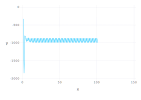

In [10]:
using Gadfly, Cairo, Fontconfig
#plot the log-likelihood
plot(x=collect(1:1:101), y=llh,Geom.line)

## The  EM approach converges to the final esitimates.

# For k = 2 

In [11]:
mu, Lambda, Psi, mu_f_by_x, Sig_f_by_x, llh = fa_em(X,2)

[10.0145; 19.9223; 30.0799; 40.0507]
[0.907577 0.455974; 0.455999 0.512312; 0.896122 0.28288; 0.250097 0.684261]
[0.833527 0.0 0.0 0.0; 0.0 0.739159 0.0 0.0; 0.0 0.0 0.47111 0.0; 0.0 0.0 0.0 0.731573]
-305.11459415426816
1
[10.0145; 19.9223; 30.0799; 40.0507]
[65.9277 448.363; -363.025 1535.61; 1051.08 -731.531; -348.645 1304.88]
[184698.0 0.0 0.0 0.0; 0.0 2.67671e6 0.0 0.0; 0.0 0.0 1.6363e6 0.0; 0.0 0.0 0.0 1.97789e6]
-1625.602905605561
2
[10.0145; 19.9223; 30.0799; 40.0507]
[0.760151 0.55129; 0.0193761 0.178414; 0.460693 -0.0237153; 0.218657 0.285511]
[101.751 0.0 0.0 0.0; 0.0 398.274 0.0 0.0; 0.0 0.0 906.157 0.0; 0.0 0.0 0.0 1604.88]
-804.3677730261089
3
[10.0145; 19.9223; 30.0799; 40.0507]
[17.2852 12.7686; 0.621957 1.98016; -1.3958 -2.23596; 5.74101 5.07412]
[558.638 0.0 0.0 0.0; 0.0 402.545 0.0 0.0; 0.0 0.0 912.923 0.0; 0.0 0.0 0.0 1662.97]
-863.688600971059
4
[10.0145; 19.9223; 30.0799; 40.0507]
[21.9349 16.181; -1.20124 12.4206; -3.7771 -6.57669; 7.03395 12.0003]
[496.684 0.0 0

[10.0145; 19.9223; 30.0799; 40.0507]
[47.3179 33.7424; -4.91466 29.5848; -16.1732 -9.34664; 12.9855 26.8085]
[2370.74 0.0 0.0 0.0; 0.0 909.204 0.0 0.0; 0.0 0.0 1133.65 0.0; 0.0 0.0 0.0 2225.58]
-961.0250035938712
43
[10.0145; 19.9223; 30.0799; 40.0507]
[8.97441 1.1752; -18.0931 23.5473; -9.67865 0.766993; -5.3397 12.6284]
[137.999 0.0 0.0 0.0; 0.0 890.98 0.0 0.0; 0.0 0.0 953.849 0.0; 0.0 0.0 0.0 1699.36]
-864.7533772362578
44
[10.0145; 19.9223; 30.0799; 40.0507]
[47.6396 33.7545; -4.96033 29.6059; -16.2878 -9.35913; 13.0674 26.8161]
[2394.75 0.0 0.0 0.0; 0.0 908.776 0.0 0.0; 0.0 0.0 1136.64 0.0; 0.0 0.0 0.0 2227.22]
-961.4260552297607
45
[10.0145; 19.9223; 30.0799; 40.0507]
[8.90981 1.17643; -18.0011 23.5543; -9.65261 0.759592; -5.31016 12.6311]
[137.317 0.0 0.0 0.0; 0.0 887.684 0.0 0.0; 0.0 0.0 953.38 0.0; 0.0 0.0 0.0 1698.98]
-864.4578636086062
46
[10.0145; 19.9223; 30.0799; 40.0507]
[47.911 33.7648; -5.00231 29.6238; -16.3847 -9.37001; 13.1347 26.8225]
[2415.14 0.0 0.0 0.0; 0.0 908.

[133.921 0.0 0.0 0.0; 0.0 864.908 0.0 0.0; 0.0 0.0 950.731 0.0; 0.0 0.0 0.0 1695.93]
-862.710479843195
82
[10.0145; 19.9223; 30.0799; 40.0507]
[49.1427 34.0304; -5.45001 29.8172; -16.8392 -9.49771; 13.3067 26.9706]
[2520.31 0.0 0.0 0.0; 0.0 911.365 0.0 0.0; 0.0 0.0 1152.48 0.0; 0.0 0.0 0.0 2236.33]
-963.6937306441765
83
[10.0145; 19.9223; 30.0799; 40.0507]
[8.57231 1.24414; -17.5553 23.3696; -9.50439 0.647813; -5.18085 12.5636]
[133.896 0.0 0.0 0.0; 0.0 864.393 0.0 0.0; 0.0 0.0 950.705 0.0; 0.0 0.0 0.0 1695.84]
-862.6833363894174
84
[10.0145; 19.9223; 30.0799; 40.0507]
[49.1396 34.049; -5.46725 29.825; -16.8392 -9.50405; 13.2967 26.9801]
[2521.02 0.0 0.0 0.0; 0.0 911.723 0.0 0.0; 0.0 0.0 1152.56 0.0; 0.0 0.0 0.0 2236.5]
-963.7207446013985
85
[10.0145; 19.9223; 30.0799; 40.0507]
[8.56986 1.24787; -17.5559 23.3548; -9.50345 0.643221; -5.18227 12.5579]
[133.875 0.0 0.0 0.0; 0.0 863.906 0.0 0.0; 0.0 0.0 950.683 0.0; 0.0 0.0 0.0 1695.75]
-862.6583171186369
86
[10.0145; 19.9223; 30.0799; 40.

([10.0145; 19.9223; 30.0799; 40.0507], [49.0707 34.1985; -5.59496 29.8777; -16.8234 -9.55403; 13.2077 27.0521], [2523.46 0.0 0.0 0.0; 0.0 914.389 0.0 0.0; 0.0 0.0 1152.85 0.0; 0.0 0.0 0.0 2237.6], [0.0069647 -0.025658; -0.00546199 0.0370073; … ; -0.0160432 -0.00459088; 0.0252097 -0.0206684], [0.476776 -0.130889; -0.130889 0.38731], [-305.115, -1625.6, -804.368, -863.689, -883.661, -919.746, -891.784, -908.954, -898.855, -904.296  …  -862.594, -963.808, -862.575, -963.826, -862.557, -963.843, -862.541, -963.859, -862.525, -963.874])

In [12]:
mu

4×1 Array{Float64,2}:
 10.0145
 19.9223
 30.0799
 40.0507

In [13]:
Lambda

4×2 Array{Float64,2}:
  49.0707   34.1985 
  -5.59496  29.8777 
 -16.8234   -9.55403
  13.2077   27.0521 

In [14]:
Psi

4×4 Array{Float64,2}:
 2523.46    0.0       0.0      0.0
    0.0   914.389     0.0      0.0
    0.0     0.0    1152.85     0.0
    0.0     0.0       0.0   2237.6

In [15]:
llh

101-element Array{Float64,1}:
  -305.115
 -1625.6  
  -804.368
  -863.689
  -883.661
  -919.746
  -891.784
  -908.954
  -898.855
  -904.296
  -910.568
  -898.639
  -921.977
     ⋮    
  -862.614
  -963.789
  -862.594
  -963.808
  -862.575
  -963.826
  -862.557
  -963.843
  -862.541
  -963.859
  -862.525
  -963.874

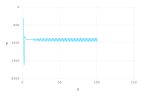

In [16]:
using Gadfly, Cairo, Fontconfig
#plot the log-likelihood
plot(x=collect(1:1:101), y=llh,Geom.line)

## 